In [1]:
import os
import functools
from warnings import simplefilter

In [2]:
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

#### Configure path parameters and read data files

The `RANDOM_SEED`, `NUM_EPOCHS`, `TRAIN_FRAC`, and `VAL_FRAC` are the same for all models during evaluaiton

In [3]:
MIDS_USER = os.getenv("MIDS_USER", None)  # this can be replaced, with e.g. `m25...`

if MIDS_USER is None:
  ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), *['..'] * 1)) 
else:
  ROOT_DIR = f"/home/mids/{MIDS_USER}/Capstone"

IMAGES_DIR = os.path.join(ROOT_DIR, "data", "datasets", "aircraft", "images")
if not os.path.exists(IMAGES_DIR):
  ROOT_DIR = os.path.join(ROOT_DIR, "lc-14")
  IMAGES_DIR = os.path.join(ROOT_DIR, "data", "datasets", "aircraft", "images")

RADOM_SEED = 2020
TRAIN_FRAC = 0.8
VAL_FRAC = 0.1

NUM_EPOCHS = 10   # This can be adjusted as needed 

In [4]:
image_dir = IMAGES_DIR
labels_fp = os.path.join(ROOT_DIR, "data", "datasets", "aircraft", "annotations.csv")

#### Load utility functions

In [5]:
os.chdir(ROOT_DIR)

In [6]:
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from src.utilities.data.aircraft_dataloader import get_dataloader

#### Define a minimal transformation pipeline

In [7]:
transformations = A.Compose([
  A.Resize(256, 256),  # This transform resizes each image before subsequent processing
  A.HorizontalFlip(p=0.5),  # This transform flips each image horizontally with a probability of 0.5
  A.RandomBrightnessContrast(p=0.2),  # This transform randomly adjusts the brightness and contrast of each image with a probability of 0.2
  A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # This transformation normalizes from standard RGB to grayscale
  ToTensorV2(),  # This transform maps our image to a torch.Tensor object
])


#### Load the baseline models

In [8]:
from src.models.baseline.cnn import BaselineCNN
from src.models.baseline.mlp import BaselineMLP
from src.models.baseline.linear import SingleLinearLayer

#### Define evaluation configuration

In [9]:
# We will use `functools.partial` to create a partial function that we can use to create instances of our models
# These will be instantiated in the training loop
default_criterion = functools.partial(nn.MSELoss)

baseline_cnn = functools.partial(BaselineCNN)
optimizer_cnn = functools.partial(
  torch.optim.Adam, 
  lr=0.01,
)

baseline_mlp = functools.partial(BaselineMLP)
optimizer_mlp = functools.partial(
  torch.optim.Adam, 
  lr=0.01,
)

single_linear_layer = functools.partial(
  SingleLinearLayer
)
optimizer_linear_layer = functools.partial(
  torch.optim.Adam,
  lr=0.01,
)


In [10]:
model_configurations = {
  "Baseline CNN": {
    "model_callable": baseline_cnn,
    "optimizer_callable": optimizer_cnn,
    "criterion_callable": default_criterion,
    "transformations": transformations,
    "dataloader_kwargs": {
      "batch_size": 4,
      "shuffle": True,
    },
  },
  "Baseline MLP": {
    "model_callable": baseline_mlp,
    "optimizer_callable": optimizer_mlp,
    "criterion_callable": default_criterion,
    "transformations": transformations,
    "dataloader_kwargs": {
      "batch_size": 4,
      "shuffle": True,
    },
  },
}

In addition to defining models argument-by-argument as above, we can also construct the dictionary dynamically. This is especially useful in cases in which we want to understand the impact of a specific change on our validation performance.

This is useful both as a form of "hyperparameter search" and also as a way of managing and comparing different models.

In [11]:
# add to the existing `model_configurations`
learning_rates_to_test = [0.05, 1e-5, 1e-7]
for lr_ in learning_rates_to_test:  
  baseline_cnn = functools.partial(
    BaselineCNN,
  )
  optimizer_cnn = functools.partial(
    torch.optim.Adam,
    lr=0.01,
  )
  model_configurations[f"Baseline CNN (lr={lr_})"] = {
    "model_callable": baseline_cnn,
    "optimizer_callable": optimizer_cnn,
    "criterion_callable": default_criterion,
    "transformations": transformations,
    "dataloader_kwargs": {
      "batch_size": 4,
      "shuffle": True,
    },
  }

### Train the models

In [12]:
for model_name, model_config in model_configurations.items():

  model = model_config["model_callable"]()
  optimizer = model_config["optimizer_callable"](params=model.parameters())
  criterion = model_config["criterion_callable"]()
  model.train()

  # Training loop
  for epoch in range(NUM_EPOCHS):

    dataloader = get_dataloader(
      image_dir=image_dir,
      labels_fp=labels_fp,
      transformations=model_config["transformations"],
      mode='train',
      train_frac=TRAIN_FRAC,
      val_frac=VAL_FRAC,
      seed=RADOM_SEED + epoch,
      batch_size=model_config["dataloader_kwargs"]["batch_size"],
      shuffle=model_config["dataloader_kwargs"]["shuffle"],
      num_workers=1,
    )

    for i, (images, targets) in enumerate(dataloader):

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs.squeeze(), targets)  # Ensure outputs are squeezed to match counts shape
      loss.backward()
      optimizer.step()

    print(f"Model {model_name} epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss.item():.4f}")
  
  model_configurations[model_name]["model"] = model


Model Baseline CNN epoch [1/10], Loss: 1229.3247
Model Baseline CNN epoch [2/10], Loss: 149.8466
Model Baseline CNN epoch [3/10], Loss: 2703.6611
Model Baseline CNN epoch [4/10], Loss: 236.0413
Model Baseline CNN epoch [5/10], Loss: 364.6329
Model Baseline CNN epoch [6/10], Loss: 15.9334
Model Baseline CNN epoch [7/10], Loss: 19.1494
Model Baseline CNN epoch [8/10], Loss: 322.9438
Model Baseline CNN epoch [9/10], Loss: 267.6472
Model Baseline CNN epoch [10/10], Loss: 156.7263
Model Baseline MLP epoch [1/10], Loss: 4682.0000
Model Baseline MLP epoch [2/10], Loss: 756.5000
Model Baseline MLP epoch [3/10], Loss: 1985.0000
Model Baseline MLP epoch [4/10], Loss: 1280.5000
Model Baseline MLP epoch [5/10], Loss: 4184.5000
Model Baseline MLP epoch [6/10], Loss: 692.0000
Model Baseline MLP epoch [7/10], Loss: 1885.0000
Model Baseline MLP epoch [8/10], Loss: 389.0000
Model Baseline MLP epoch [9/10], Loss: 1938.5000
Model Baseline MLP epoch [10/10], Loss: 904.0000
Model Baseline CNN (lr=0.05) epo

### Evaluate the models

In [13]:
model_losses = {
  model_name: [] for model_name in model_configurations.keys()
}
model_predictions = {
  model_name: [] for model_name in model_configurations.keys()
}


In [14]:
for model_name, model_config in model_configurations.items():
  
  val_dataloader = get_dataloader(
    image_dir,
    labels_fp,
    transformations=transformations,
    mode='val',
    train_frac=TRAIN_FRAC,
    val_frac=VAL_FRAC,
    seed=RADOM_SEED,
    batch_size=1,
    shuffle=True,
    num_workers=1,
  )
  true_labels = []

  model = model_config["model"]
  model.eval()

  for i, (val_images, targets) in enumerate(val_dataloader):
    predicted_counts = model(val_images)
    # We validate based on the mean absolute error
    model_losses[model_name].append(torch.abs(predicted_counts - targets).item())
    model_predictions[model_name].append(predicted_counts.item())
    true_labels.append(targets.item())
    print(f"{model_name} - val image {i+1}, predicted count: {predicted_counts.item():.4f}, true count: {targets.item():.4f}")


Baseline CNN - val image 1, predicted count: 5.0628, true count: 31.0000
Baseline CNN - val image 2, predicted count: 34.4091, true count: 49.0000
Baseline CNN - val image 3, predicted count: 29.3623, true count: 39.0000
Baseline CNN - val image 4, predicted count: 16.7419, true count: 27.0000
Baseline CNN - val image 5, predicted count: 18.3813, true count: 19.0000
Baseline CNN - val image 6, predicted count: 14.2363, true count: 24.0000
Baseline CNN - val image 7, predicted count: 35.3785, true count: 52.0000
Baseline CNN - val image 8, predicted count: 0.0000, true count: 15.0000
Baseline CNN - val image 9, predicted count: 11.3849, true count: 26.0000
Baseline CNN - val image 10, predicted count: 9.8839, true count: 30.0000
Baseline MLP - val image 1, predicted count: 0.0000, true count: 31.0000
Baseline MLP - val image 2, predicted count: 0.0000, true count: 49.0000
Baseline MLP - val image 3, predicted count: 0.0000, true count: 39.0000
Baseline MLP - val image 4, predicted count

### Compare the models

In [15]:
for model_name, model_losses in model_losses.items():
  print(f"Model {model_name} MAE: {sum(model_losses) / len(model_losses):.4f}")


Model Baseline CNN MAE: 13.7159
Model Baseline MLP MAE: 31.2000
Model Baseline CNN (lr=0.05) MAE: 9.8012
Model Baseline CNN (lr=1e-05) MAE: 31.2000
Model Baseline CNN (lr=1e-07) MAE: 31.2000


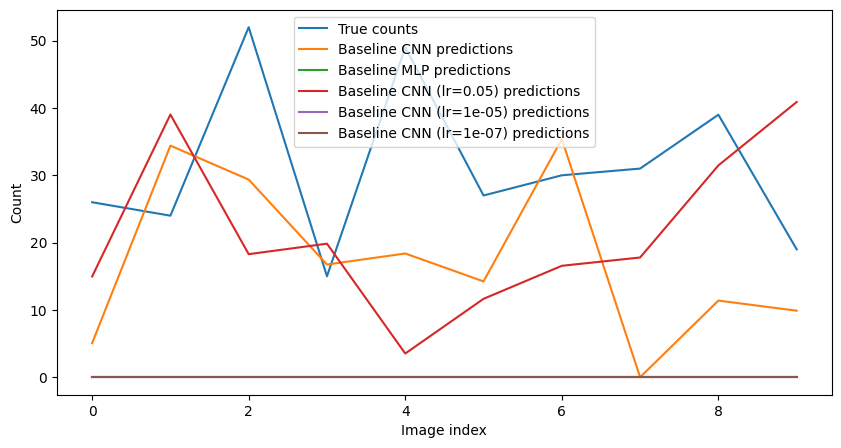

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(true_labels, label="True counts")
for model_name, model_prediction in model_predictions.items():
  plt.plot(model_prediction, label=f"{model_name} predictions")
plt.xlabel("Image index")
plt.ylabel("Count")
plt.legend()
plt.show()
